In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)

# Analysis of Bias symptoms

The goal of the analysis is to identify symptoms that allow to predict the value of some bias metrics without training a classification model. 

The metrics are the following:

- **Statistical Parity:**

$$
SP = P(\hat{Y} = 1 | A = 0) - P(\hat{Y} = 1 | A = 1)
$$

- **Equal Opportunity:**

$$
EO = P(\hat{Y} = 1 | A = 0, Y = 1) - P(\hat{Y} = 1 | A = 1, Y = 1)
$$

- **Average Odds:**

$$
AO = \left[ P(\hat{Y} = 1 | A = 0, Y = 1) - P(\hat{Y} = 1 | A = 1, Y = 1) \right] \\ + \left[ P(\hat{Y} = 1 | A = 0, Y = 0) - P(\hat{Y} = 1 | A = 1, Y = 0) \right]
$$

The considered symptoms are the following:

- **Correlation**: Kendall correlation factor between the sensitive attribute and the label
- **Mutual Information**: Mutual information between the sensitive attribute and the label
- **Unprivileged Positive Probability**: Probability of the label being 1 given the sensitive attribute is 0
- **Privileged Positive Probability**: Probability of the label being 1 given the sensitive attribute is 1
- **Unprivileged Negative Probability**: Probability of the label being 0 given the sensitive attribute is 0
- **Privileged Negative Probability**: Probability of the label being 0 given the sensitive attribute is 1
- **Positive Probability Difference**: Difference between the unprivileged positive probability and the privileged positive probability
- **Negative Probability Difference**: Difference between the unprivileged negative probability and the privileged negative probability
- **Group Unbalance**: Ratio between the number of samples with sensitive attribute 0 and the number of samples with sensitive attribute 1
- **Label Unbalance**: Ratio between the number of samples with label 0 and the number of samples with label 1


In [21]:
data = pd.read_csv("bias_symptoms.csv")
# data.drop(columns=["correlation_pred"], inplace=True)
# data.dropna(inplace=True)
# data.rename(columns={"unpriv_prob": "unpriv_prob_pos", "priv_prob": "priv_prob_pos"}, inplace=True)
# data['unpriv_prob_neg'] = 1 - data['unpriv_prob_pos']
# data['priv_prob_neg'] = 1 - data['priv_prob_pos']
# data['pos_prob'] = data['unpriv_prob_pos'] - data['priv_prob_pos']
# data['neg_prob'] = data['unpriv_prob_neg'] - data['priv_prob_neg']
# data.set_index(['variable', 'data'], inplace=True)
# data.to_csv("bias_symptoms.csv")

## Percentage of variables detected as biased by the different metrics

In [3]:
threshold = 0.2

In [4]:
stat_par = data[data.statistical_parity.abs() > threshold]
stat_par = stat_par.shape[0] / data.shape[0]
eq_odds = data[data.equal_opportunity.abs() > threshold]
eq_odds = eq_odds.shape[0] / data.shape[0]
av_odds = data[data.average_odds.abs() > threshold]
av_odds = av_odds.shape[0] / data.shape[0]

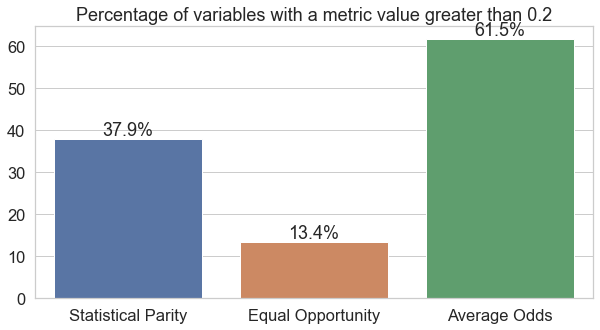

In [5]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=["Statistical Parity", "Equal Opportunity", "Average Odds"], 
            y=[stat_par*100, eq_odds*100, av_odds*100])
plt.bar_label(ax.containers[0], fmt='%.1f%%', label_type='edge')
plt.title("Percentage of variables with a metric value greater than 0.2")
plt.show()

## Distribution of bias metrics values

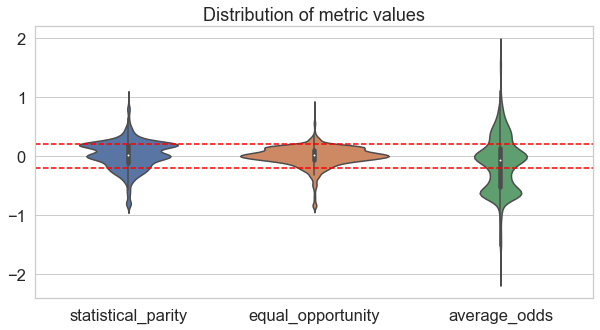

In [6]:
plt.figure(figsize=(10, 5))
ax = sns.violinplot(
    data=data[["statistical_parity", "equal_opportunity", "average_odds"]],
)
plt.axhline(y=0.2, color="red", linestyle="--")
plt.axhline(y=-0.2, color="red", linestyle="--")
plt.title("Distribution of metric values")
plt.show()

## Correlation Analysis

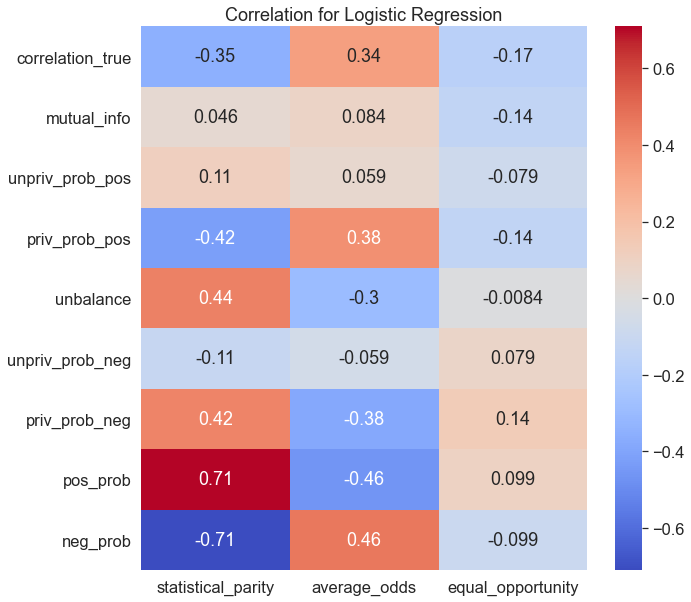

In [7]:
correlation = data.corr("pearson")

plt.figure(figsize=(10, 10))

sns.heatmap(
  correlation[['statistical_parity', 'average_odds', 'equal_opportunity']].drop(['statistical_parity', 'average_odds', 'equal_opportunity'], axis=0), 
  annot=True, 
  cmap="coolwarm")
plt.title("Correlation for Logistic Regression")
plt.show()

## Analysis of the symptoms distribution

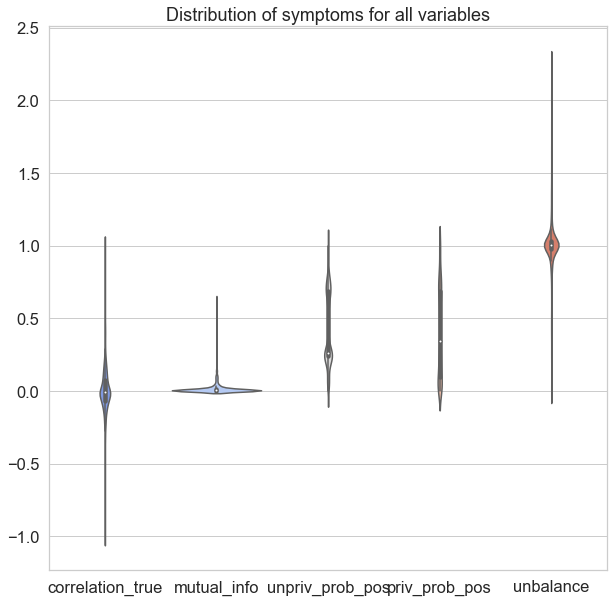

In [8]:
plt.figure(figsize=(10, 10))
sns.violinplot(
    data=data[["correlation_true", "mutual_info", "unpriv_prob_pos", "priv_prob_pos", "unbalance"]],
    palette="coolwarm"
)
plt.title("Distribution of symptoms for all variables")
plt.show()

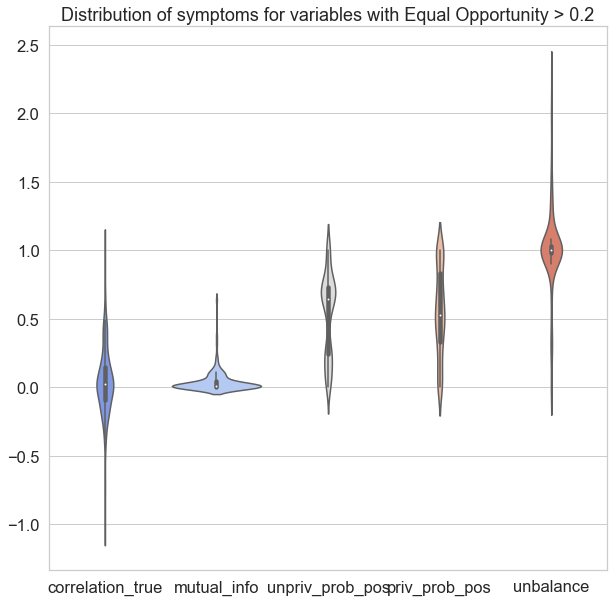

In [9]:
data_new = data[data["equal_opportunity"].abs() > 0.2]
plt.figure(figsize=(10, 10))
sns.violinplot(
    data=data_new[
        ["correlation_true", "mutual_info", "unpriv_prob_pos", "priv_prob_pos", "unbalance"]
    ],
    palette="coolwarm",
)
plt.title("Distribution of symptoms for variables with Equal Opportunity > 0.2")
plt.show()

## Predicting the metrics from the symptoms

In [86]:
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [16]:
def train_model(model, data, label):
    scores = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    for itrain, itest in kfold.split(data):
        train, test = data.iloc[itrain], data.iloc[itest]
        model.fit(
            train.drop(
                columns=["statistical_parity", "equal_opportunity", "average_odds"]
            ),
            train[label],
        )
        scores.append(
            model.score(
                test.drop(
                    columns=["statistical_parity", "equal_opportunity", "average_odds"]
                ),
                test[label],
            )
        )
    return scores

### Statistical Parity with Linear Regression

In [20]:
model = LinearRegression()
sp_linreg_symp = train_model(model, data, "statistical_parity")

In [21]:
np.mean(sp_linreg_symp)

0.5315569294549374

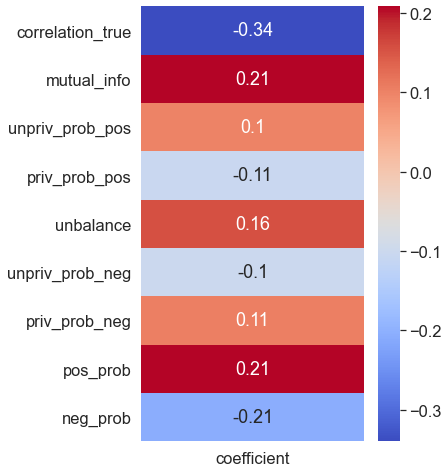

In [19]:
plt.figure(figsize=(5, 8))
sns.heatmap(pd.DataFrame(model.coef_, index=data.drop(columns=["statistical_parity", "equal_opportunity", "average_odds"]).columns, columns=['coefficient']), annot=True, cmap="coolwarm")
plt.show()

### Statistical Parity with XGBoost

In [87]:
model = XGBRegressor()
sp_xgb_symp = train_model(model, data, "statistical_parity")

In [23]:
np.mean(sp_xgb_symp)

0.42081206652413117

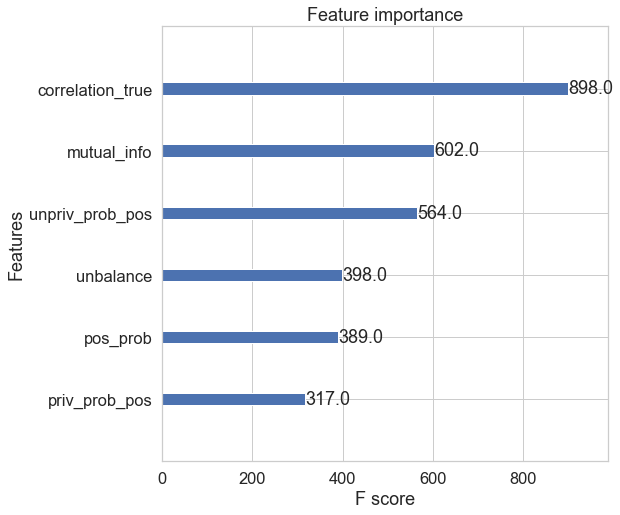

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, ax)
plt.show()

### Equal Opportunity with Linear Regression

In [24]:
model = LinearRegression()
ep_linreg_symp = train_model(model, data, "equal_opportunity")

In [25]:
np.mean(ep_linreg_symp)

0.028953308833070235

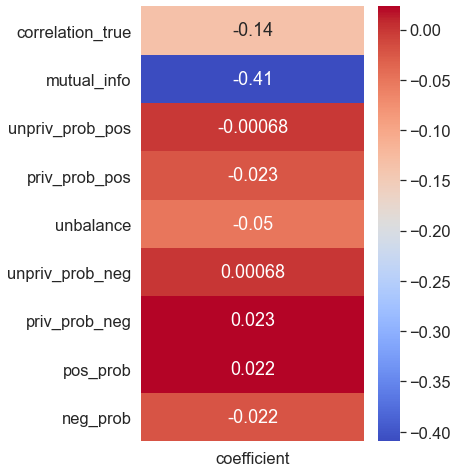

In [26]:
plt.figure(figsize=(5, 8))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=data.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Equal Opportunity with XGBoost

In [90]:
model = XGBRegressor()
eo_xgb_symp = train_model(model, data, "equal_opportunity")

In [28]:
np.mean(eo_xgb_symp)

-0.02824018634766976

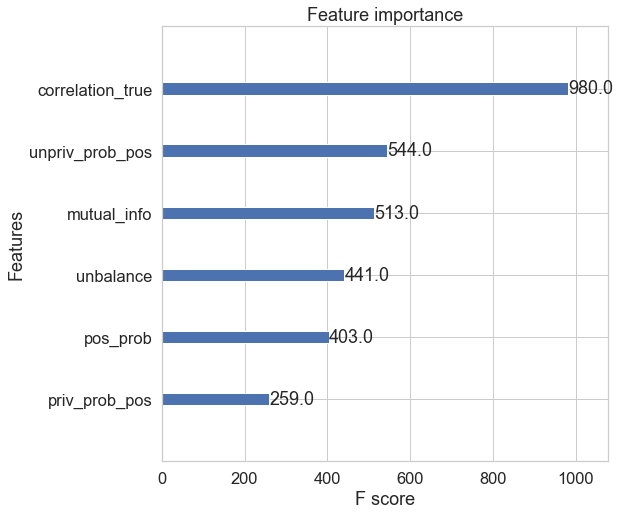

In [92]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, ax)
plt.show()

### Average Odds with Linear Regression

In [29]:
model = LinearRegression()
ao_linreg_symp = train_model(model, data, "average_odds")

In [30]:
np.mean(ao_linreg_symp)

0.27978721301994264

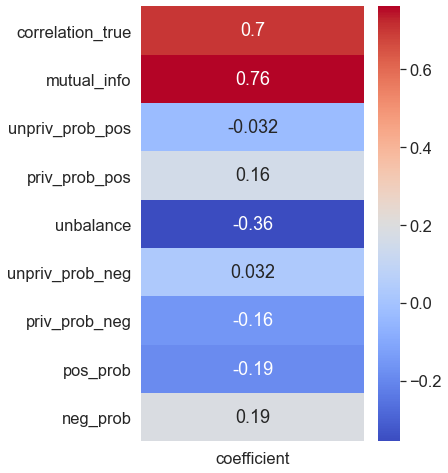

In [32]:
plt.figure(figsize=(5, 8))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=data.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Average Odds with XGBoost

In [93]:
model = XGBRegressor()
ao_xgb_symp = train_model(model, data, "average_odds")

In [94]:
np.mean(ao_xgb_symp)

0.4143744774030981

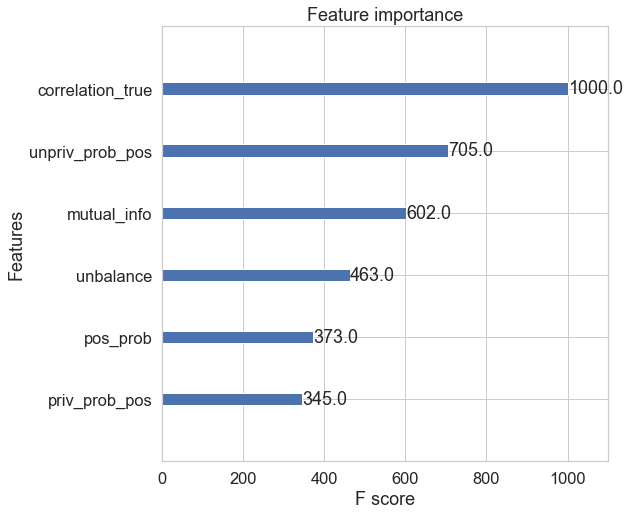

In [95]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, ax)
plt.show()

## Predicting the metrics from the metafeatures alone

In [7]:
meta = pd.read_csv("metafeatures.csv", index_col=0)
meta.rename(columns={"dataset_name": "data"}, inplace=True)
meta['data'] = meta.data.apply(lambda x: x.split(".")[0])
meta['data'] = meta.data.apply(lambda x: x.split("_")[0])
meta.set_index(["variable", "data"], inplace=True)
meta.drop(meta.index.unique(level=1).difference(data.index.unique(level=1)), level=1, inplace=True)
meta_new = meta.join(data[['statistical_parity', 'equal_opportunity', 'average_odds']])
meta_new.dropna(inplace=True)
meta_new.drop_duplicates(inplace=True)

In [8]:
meta_new.to_csv("metafeatures.csv")

In [17]:
data

,,correlation_true,mutual_info,unpriv_prob_pos,priv_prob_pos,unbalance,statistical_parity,equal_opportunity,average_odds,unpriv_prob_neg,priv_prob_neg,pos_prob,neg_prob
variable,data,,,,,,,,,,,,
race,adult,0.084531,0.004036,0.129252,0.252500,0.536785,-0.167058,-0.055782,0.443037,0.870748,0.747500,-0.123248,0.123248
sex,adult,0.230065,0.029482,0.101744,0.310378,0.422546,-0.157207,-0.127140,0.116649,0.898256,0.689622,-0.208634,0.208634
10th,adult,-0.079627,0.004225,0.246914,0.051546,1.025437,0.191191,0.118290,-0.619008,0.753086,0.948454,0.195367,-0.195367
11th,adult,-0.091252,0.005677,0.248489,0.043103,1.031979,0.192411,0.127817,-0.619651,0.751511,0.956897,0.205385,-0.205385
12th,adult,-0.051403,0.001712,0.243518,0.063830,1.011336,0.144844,0.060667,-0.569643,0.756482,0.936170,0.179688,-0.179688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
type,wine,0.085865,0.005864,0.384615,0.476510,0.852241,-0.159525,0.014760,0.299304,0.615385,0.523490,-0.091895,0.091895
alcohol,wine,0.363793,0.081020,0.404580,0.497175,0.883764,-0.640531,-0.015267,1.253022,0.595420,0.502825,-0.092595,0.092595
type,wine,0.142046,0.013685,0.416667,0.469008,0.910165,-0.235537,-0.039945,0.467955,0.583333,0.530992,-0.052342,0.052342


In [19]:
meta_new.loc[("race", "adult")]

instance_num  log_inst_num  class_num  feat_num  log_feat_num  \
variable data                                                                   
race     adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
...                      ...           ...        ...       ...           ...   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   
         adult          3094       8.03722          2       102      4.624973   

                inst_missing_vals  perc_inst_missing_val  feat_missing_val  \
variable data                                                                
race     adult                  0                      0                 0   
         adult                  0                      0                 0   
         adult                  0                      0                 0   
         adult                  0                      0                 0   
         adult                  0                      0                 0   
...                           ...                    ...               ...   
         adult                  0                      0                 0   
         adult                  0                      0                 0   
         adult                  0                      0                 0   
         adult                  0                      0                 0   
         adult                  0                      0                 0   

                perc_feat_missing_val  missing_vals  ...  kurtosis_var  \
variable data                                        ...                 
race     adult                      0             0  ...      5.639858   
         adult                      0             0  ...      5.639858   
         adult                      0             0  ...      5.639858   
         adult                      0             0  ...      5.639858   
         adult                      0             0  ...      5.639858   
...                               ...           ...  ...           ...   
         adult                      0             0  ...      5.465570   
         adult                      0             0  ...      5.465570   
         adult                      0             0  ...      5.465570   
         adult                      0             0  ...      5.465570   
         adult                      0             0  ...      5.465570   

                skew_min   skew_max  skew_mean   skew_std  skew_var  \
variable data                                                         
race     adult -3.085848  55.623736   11.07327  14.512954 -2.763370   
         adult -3.085848  55.623736   11.07327  14.512954 -2.763370   
         adult -3.085848  55.623736   11.07327  14.512954 -2.763370   
         adult -3.085848  55.623736   11.07327  14.512954 -2.763370   
         adult -3.085848  55.623736   11.07327  14.512954 -2.763370   
...                  ...        ...        ...        ...       ...   
         adult -3.022972  55.623736   13.59251  17.045220 -2.731673   
         adult -3.022972  55.623736   13.59251  17.045220 -2.731673   
         adult -3.022972  55.623736   13.59251  17.045220 -2.731673   
         adult -3.022972  55.623736   13.59251  17.045220 -2.731673   
         adult -3.022972  55.623736   13.59251  17.045220 -2.731673   

                class_entropy  statistical_parity  equal_opp

In [18]:
data.loc[('race', 'adult')]

C:\Users\giord\AppData\Local\Temp/ipykernel_3696/121561342.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[('race', 'adult')]


correlation_true  mutual_info  unpriv_prob_pos  priv_prob_pos  \
variable data                                                                   
race     adult          0.084531     0.004036         0.129252       0.252500   
         adult          0.093535     0.004963         0.129032       0.264009   
         adult          0.051753     0.001430         0.170968       0.244253   
         adult          0.110169     0.007078         0.107143       0.258883   
         adult          0.105177     0.006400         0.109827       0.251456   
         adult          0.091520     0.004762         0.123418       0.252340   
         adult          0.089406     0.004515         0.128931       0.255043   
         adult          0.100228     0.005776         0.118971       0.263026   
         adult          0.087194     0.004320         0.126761       0.256584   
         adult          0.112357     0.007512         0.096990       0.260465   

                unbalance  statistical_parity  equal_opportunity  \
variable data                                                      
race     adult   0.536785           -0.167058          -0.055782   
         adult   0.515130           -0.131653          -0.079584   
         adult   0.721656           -0.140232          -0.043727   
         adult   0.442000           -0.139956          -0.066836   
         adult   0.466123           -0.136667          -0.071739   
         adult   0.516020           -0.131604          -0.085903   
         adult   0.532593           -0.131398          -0.064191   
         adult   0.478669           -0.149186          -0.055642   
         adult   0.518094           -0.124708          -0.062019   
         adult   0.396416           -0.145866          -0.081668   

                average_odds  unpriv_prob_neg  priv_prob_neg  pos_prob  \
variable data                                                            
race     adult      0.443037         0.870748       0.747500 -0.123248   
         adult      0.168637         0.870968       0.735991 -0.134976   
         adult      0.320025         0.829032       0.755747 -0.073285   
         adult      0.250315         0.892857       0.741117 -0.151740   
         adult      0.255805         0.890173       0.748544 -0.141629   
         adult      0.185658         0.876582       0.747660 -0.128922   
         adult      0.238159         0.871069       0.744957 -0.126112   
         adult      0.323115         0.881029       0.736974 -0.144054   
         adult      0.222988         0.873239       0.743416 -0.129823   
         adult      0.250483         0.903010       0.739535 -0.163475   

                neg_prob  
variable data             
race     adult  0.123248  
         adult  0.134976  
         adult  0.073285  
         adult  0.151740  
         adult  0.141629  
         adult  0.128922  
         adult  0.126112  
         adult  0.144054  
         adult  0.129823  
         adult  0.163475

In [9]:
meta_new

instance_num  log_inst_num  class_num  feat_num  \
variable  data                                                     
 10th     adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
...                       ...           ...        ...       ...   
wife_work cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   

                 log_feat_num  inst_missing_vals  perc_inst_missing_val  \
variable  data                                                            
 10th     adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
...                       ...                ...                    ...   
wife_work cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   

                 feat_missing_val  perc_feat_missing_val  missing_vals  ...  \
variable  data                                                          ...   
 10th     adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
...                           ...                    ...           ...  ...   
wife_work cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   

                 kurtosis_var  skew_min   skew_max  skew_mean   skew_std  \
variable  data                                                             
 10th     adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
...                       ...       ...        ...        ...        ...   
wife_work cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   

                 skew_var  class_entropy  statistical_parity  \
variable  data                                                 
 10th     a

### Predicting Statistical Parity with Linear Regression

In [48]:
model = LinearRegression()
sp_linreg_meta = train_model(model, meta_new, "statistical_parity")

In [49]:
np.mean(sp_linreg_meta)

0.07435869449470703

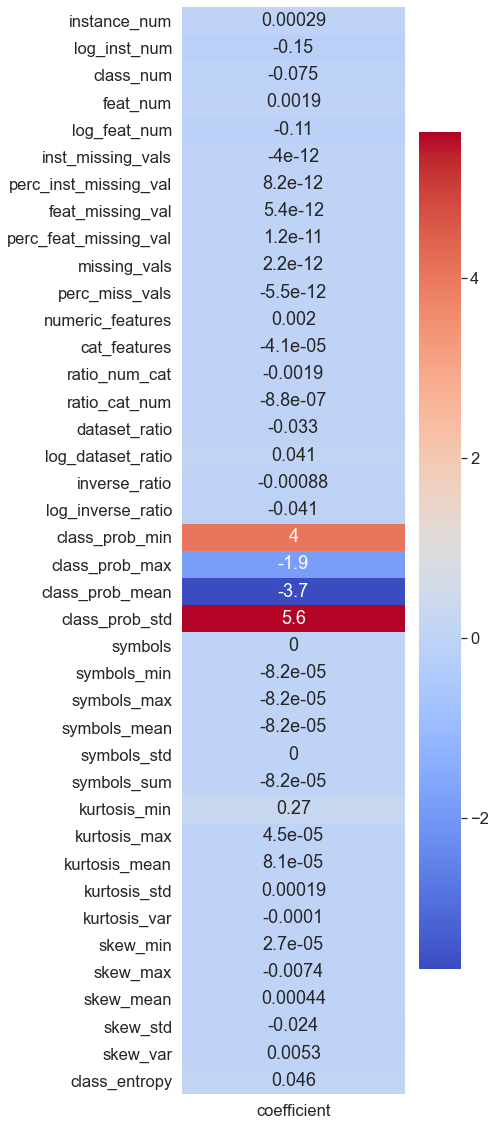

In [51]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=meta_new.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Statistical Parity with XGBoost

In [96]:
model = XGBRegressor()
sp_xgb_meta = train_model(model, meta_new, "statistical_parity")

In [53]:
np.mean(sp_xgb_meta)

0.4553313447416267

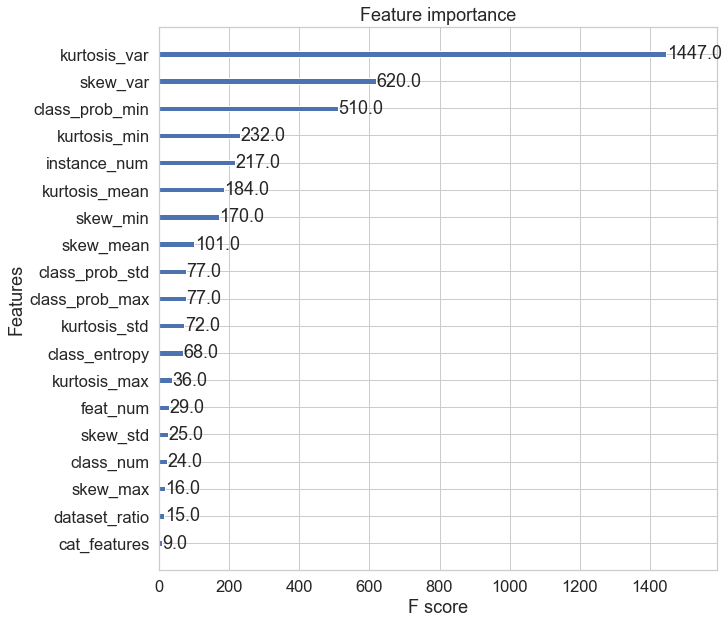

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Equal Opportunity with Linear Regression

In [54]:
model = LinearRegression()
ep_linreg_meta = train_model(model, meta_new, "equal_opportunity")

In [55]:
np.mean(ep_linreg_meta)

0.03713423836318157

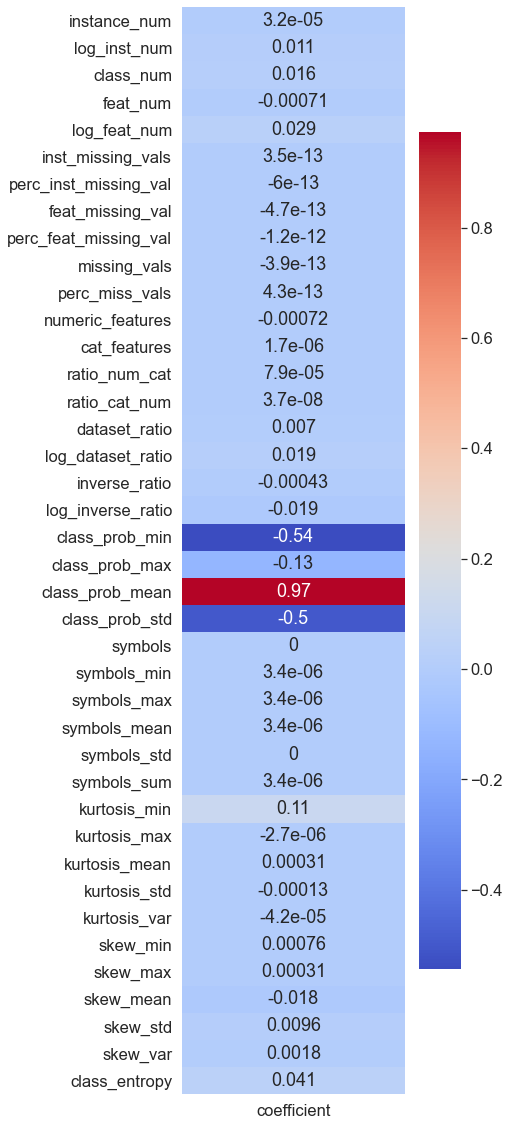

In [57]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=meta_new.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Equal Opportunity with XGBoost

In [98]:
model = XGBRegressor()
ep_xgb_meta = train_model(model, meta_new, "equal_opportunity")

In [59]:
np.mean(ep_xgb_meta)

0.17119154310695409

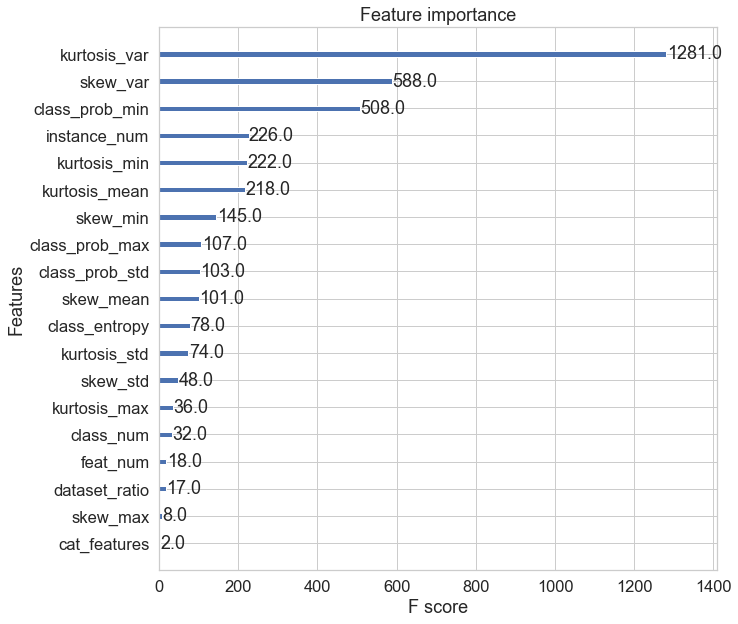

In [99]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Average Odds with Linear Regression

In [100]:
model = LinearRegression()
ao_linreg_meta = train_model(model, meta_new, "average_odds")

In [61]:
np.mean(ao_linreg_meta)

0.12472081131646173

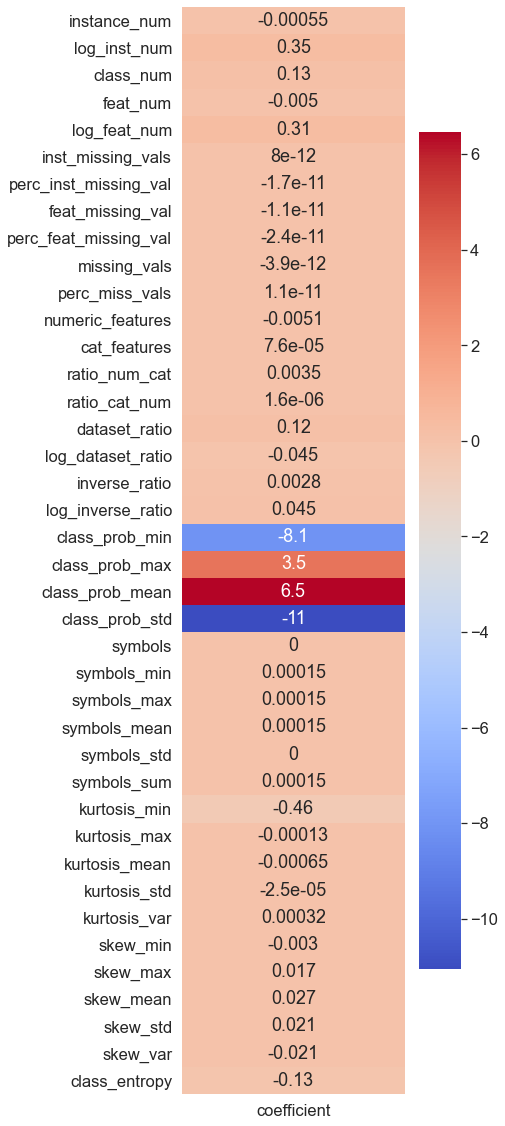

In [62]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=meta_new.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Average Odds with XGBoost

In [101]:
model = XGBRegressor()
ao_xgb_meta = train_model(model, meta_new, "average_odds")

In [64]:
np.mean(ao_xgb_meta)

0.503553174934327

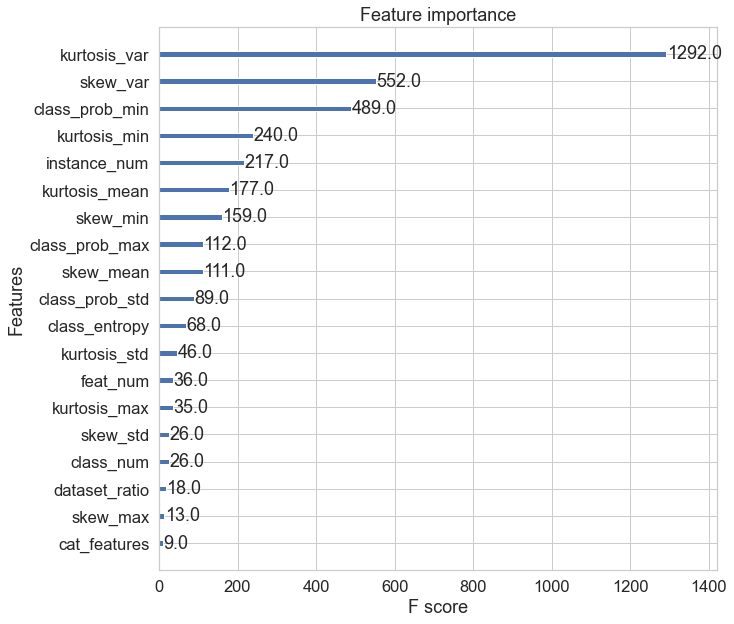

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

## Predicting the metrics from the symptoms and the metafeatures

In [5]:
joined = data.join(meta, how="inner").dropna()
joined.drop_duplicates(inplace=True)
joined

correlation_true  mutual_info  unpriv_prob_pos  \
variable  data                                                    
 10th     adult         -0.079627     0.004225         0.246914   
          adult         -0.079627     0.004225         0.246914   
          adult         -0.079627     0.004225         0.246914   
          adult         -0.079627     0.004225         0.246914   
          adult         -0.079627     0.004225         0.246914   
...                           ...          ...              ...   
wife_work cmc           -0.008450     0.000045         0.179487   
          cmc           -0.008450     0.000045         0.179487   
          cmc           -0.008450     0.000045         0.179487   
          cmc           -0.008450     0.000045         0.179487   
          cmc           -0.008450     0.000045         0.179487   

                 priv_prob_pos  unbalance  statistical_parity  \
variable  data                                                  
 10th     adult       0.051546   1.025437            0.191191   
          adult       0.051546   1.025437            0.191191   
          adult       0.051546   1.025437            0.191191   
          adult       0.051546   1.025437            0.191191   
          adult       0.051546   1.025437            0.191191   
...                        ...        ...                 ...   
wife_work cmc         0.175926   1.014793            0.071225   
          cmc         0.175926   1.014793            0.071225   
          cmc         0.175926   1.014793            0.071225   
          cmc         0.175926   1.014793            0.071225   
          cmc         0.175926   1.014793            0.071225   

                 equal_opportunity  average_odds  unpriv_prob_neg  \
variable  data                                                      
 10th     adult           0.118290     -0.619008         0.753086   
          adult           0.118290     -0.619008         0.753086   
          adult           0.118290     -0.619008         0.753086   
          adult           0.118290     -0.619008         0.753086   
          adult           0.118290     -0.619008         0.753086   
...                            ...           ...              ...   
wife_work cmc             0.096154     -0.091437         0.820513   
          cmc             0.096154     -0.091437         0.820513   
          cmc             0.096154     -0.091437         0.820513   
          cmc             0.096154     -0.091437         0.820513   
          cmc             0.096154     -0.091437         0.820513   

                 priv_prob_neg  ...  kurtosis_max  kurtosis_mean  \
variable  data                  ...                                
 10th     adult       0.948454  ...   3094.000000     331.712452   
          adult       0.948454  ...   3094.000000     526.625223   
          adult       0.948454  ...   3094.000000     419.541727   
          adult       0.948454  ...   3094.000000     445.913717   
          adult       0.948454  ...   3094.000000     343.553902   
...                        ...  ...           ...            ...   
wife_work cmc         0.824074  ...     10.155691       1.028938   
          cmc         0.824074  ...      8.780898       0.455269   
          cmc         0.824074  ...     10.155691       1.043423   
          cmc         0.824074  ...      7.636720       0.576550   
          cmc         0.824074  ...      5.842650       0.351060   

                 kurtosis_std  kurtosis_var  skew_min   skew_max  skew_mean  \
variable  data                                                                
 10th     adult    719.596527     26.974784 -3.085848  55.623736  11.073270   
          adult    973.281611     28.709394 -3.085848  55.623736  14.332207   
          adult    822.087233     27.646695 -3.054070  55.623736  12.814591   
          adult    835.083733     29.079213 -3.110143  55.623736  13.483988   
          adult    698.205028     29.84380

In [6]:
joined.to_csv("all_features.csv")

### Predicting Statistical Parity with Linear Regression

In [66]:
model = LinearRegression()
sp_linreg_joined = train_model(model, joined, "statistical_parity")

In [67]:
np.mean(sp_linreg_joined)

0.5860627567672081

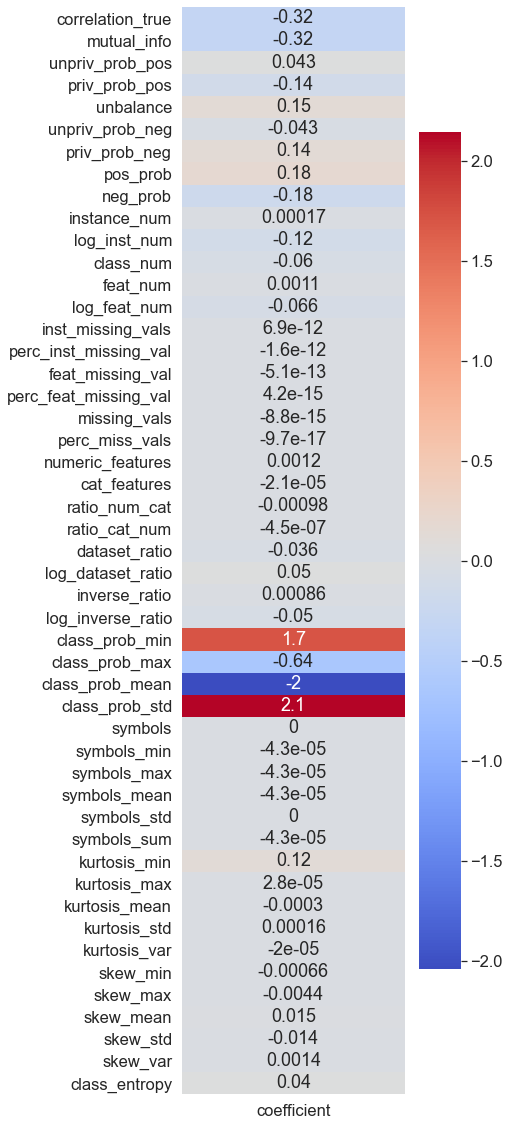

In [68]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=joined.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Statistical Parity with XGBoost

In [103]:
model = XGBRegressor()
sp_xgb_joined = train_model(model, joined, "statistical_parity")

In [70]:
np.mean(sp_xgb_joined)

0.8165475410571984

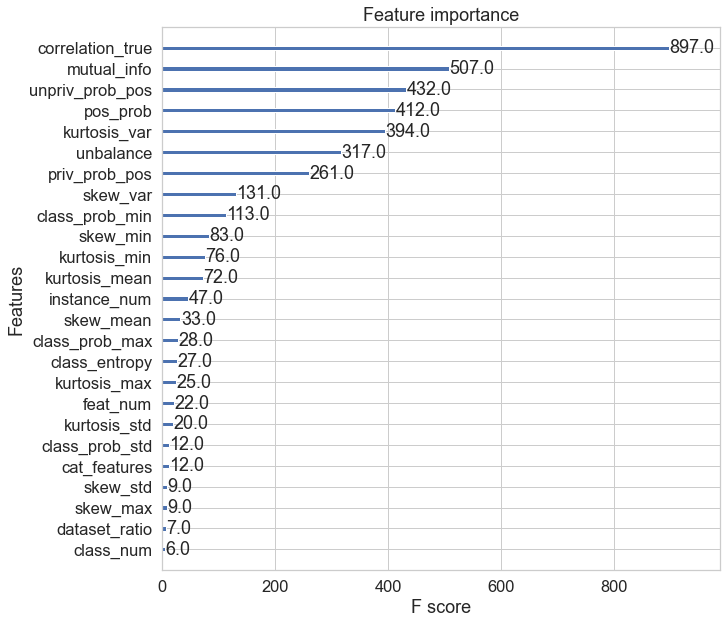

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Equal Opportunity with Linear Regression

In [71]:
model = LinearRegression()
ep_linreg_joined = train_model(model, joined, "equal_opportunity")

In [72]:
np.mean(ep_linreg_joined)

0.0894031920389077

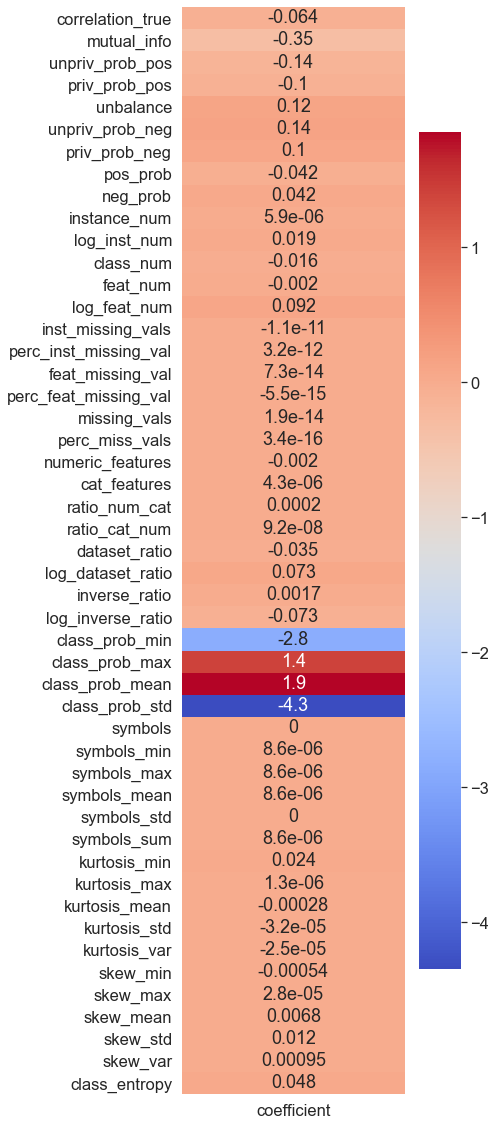

In [73]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=joined.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Equal Opportunity with XGBoost

In [105]:
model = XGBRegressor()
ep_xgb_joined = train_model(model, joined, "equal_opportunity")

In [75]:
np.mean(ep_xgb_joined)

0.6484021815285821

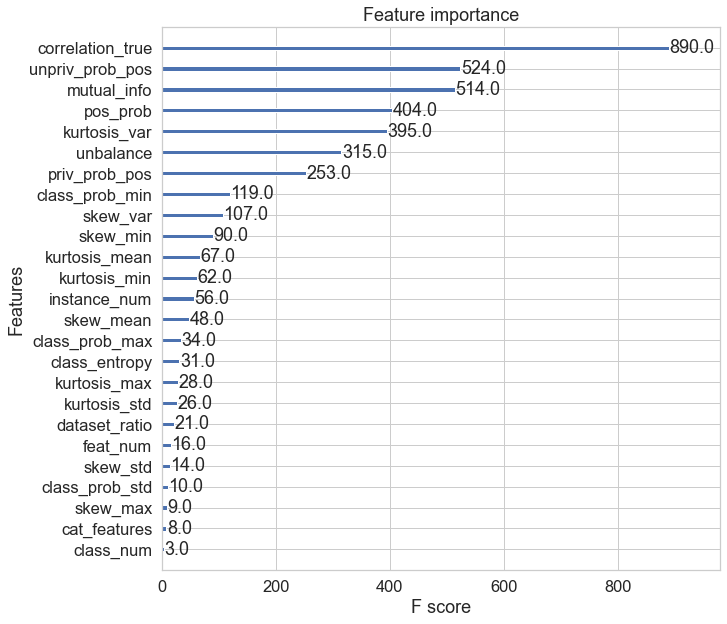

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Average Odds with Linear Regression

In [76]:
model = LinearRegression()
ao_linreg_joined = train_model(model, joined, "average_odds")

In [77]:
np.mean(ao_linreg_joined)

0.3917389828366006

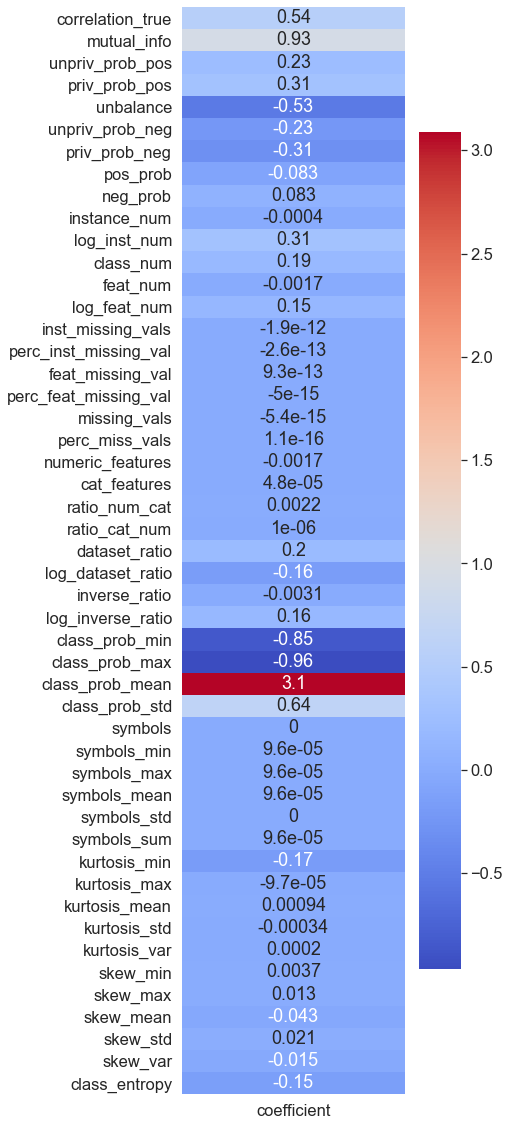

In [78]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=joined.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Average Odds with XGBoost

In [79]:
model = XGBRegressor()
ao_xgb_joined = train_model(model, joined, "average_odds")

In [80]:
np.mean(ao_xgb_joined)

0.8843931947520034

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

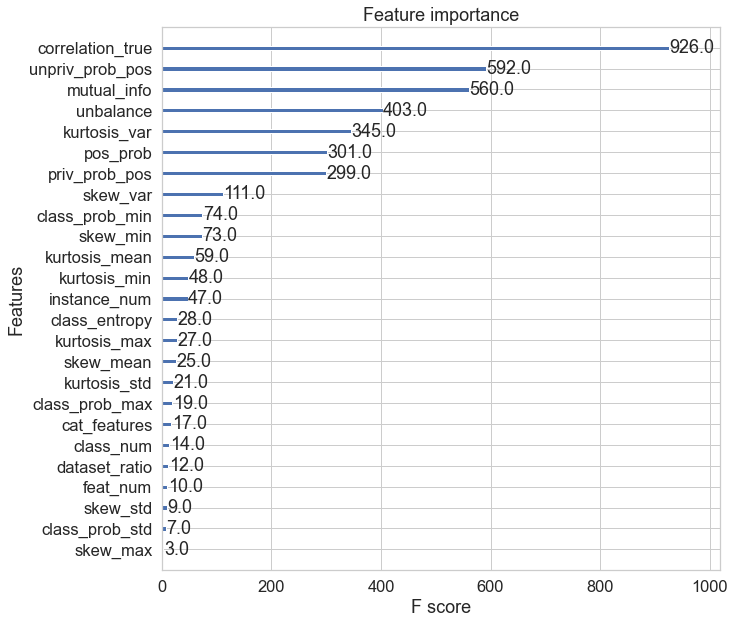

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

## Comparison of the results

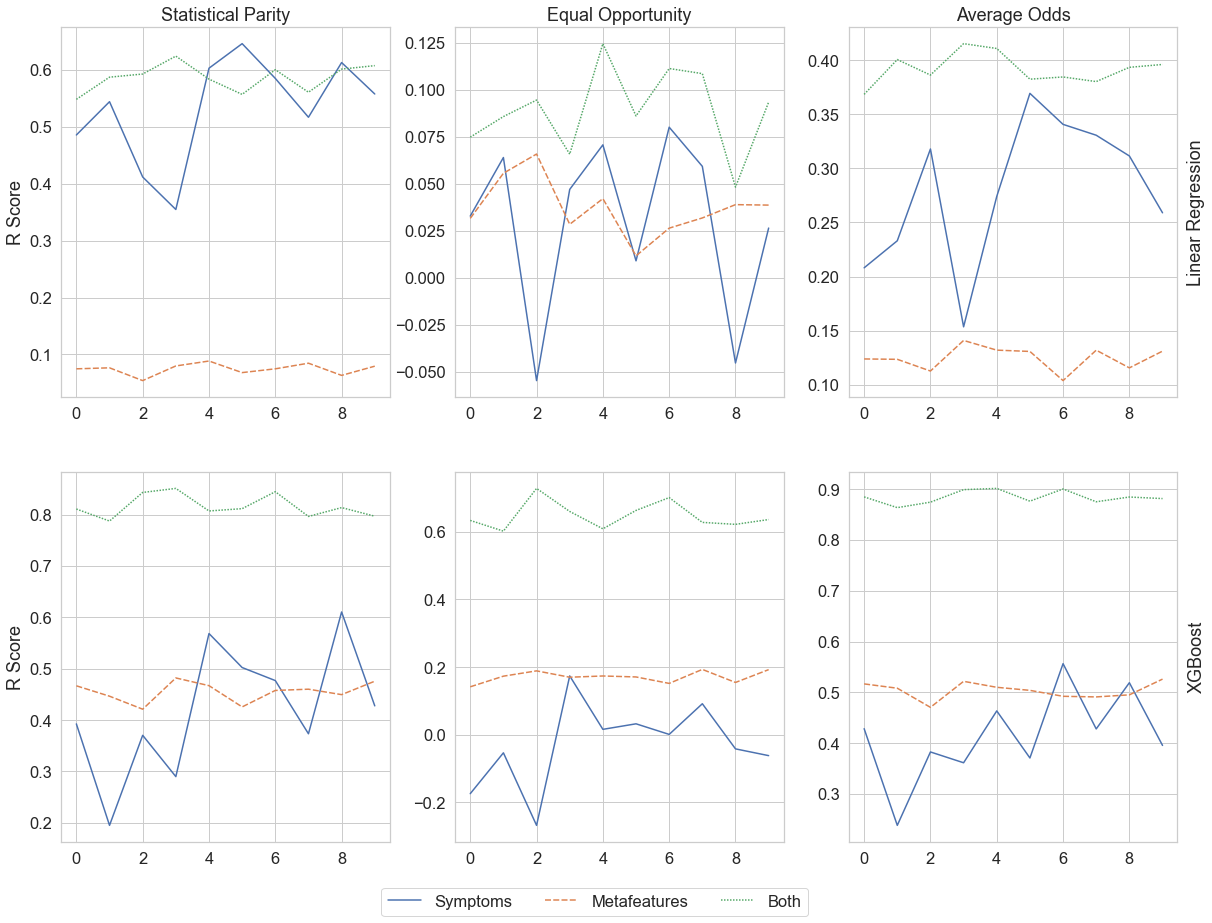

In [155]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

sns.lineplot(
    data=[sp_linreg_symp, sp_linreg_meta, sp_linreg_joined], ax=ax[0, 0], legend=False
)
sns.lineplot(
    data=[ep_linreg_symp, ep_linreg_meta, ep_linreg_joined], ax=ax[0, 1], legend=False
)
sns.lineplot(
    data=[ao_linreg_symp, ao_linreg_meta, ao_linreg_joined], ax=ax[0, 2], legend=False
)
sns.lineplot(data=[sp_xgb_symp, sp_xgb_meta, sp_xgb_joined], ax=ax[1, 0], legend=False)
sns.lineplot(data=[eo_xgb_symp, ep_xgb_meta, ep_xgb_joined], ax=ax[1, 1], legend=False)
sns.lineplot(data=[ao_xgb_symp, ao_xgb_meta, ao_xgb_joined], ax=ax[1, 2], legend=False)

plt.legend(
    ["Symptoms", "Metafeatures", "Both"],
    loc="upper right",
    bbox_to_anchor=(-0.1, -0.1),
    ncol=3,
)
ax[0, 0].set_title("Statistical Parity")
ax[0, 1].set_title("Equal Opportunity")
ax[0, 2].set_title("Average Odds")
ax[0, 0].set_ylabel("R Score")
ax[1, 0].set_ylabel("R Score")
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Linear Regression", labelpad=10)
ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("XGBoost", labelpad=10)
plt.show()

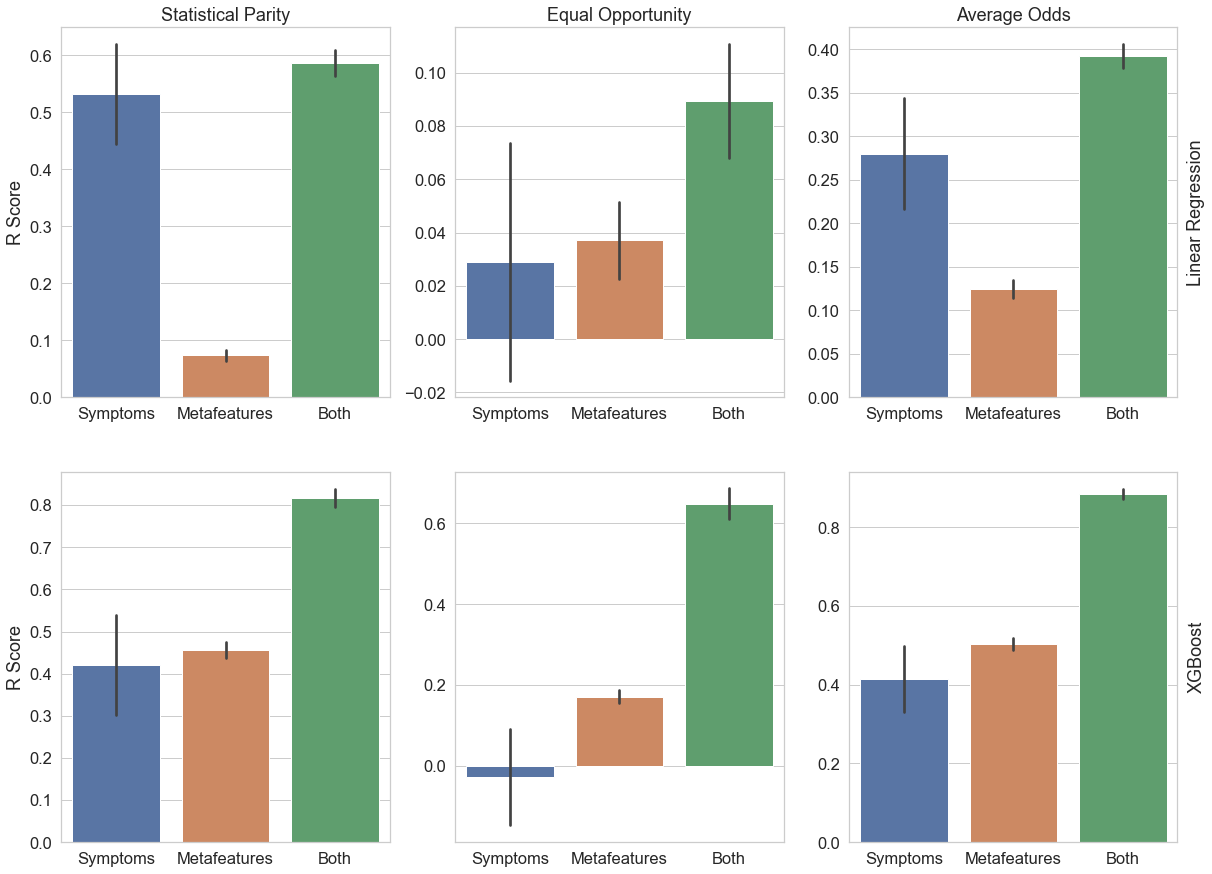

In [156]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

sns.barplot(
    data=[sp_linreg_symp, sp_linreg_meta, sp_linreg_joined], ci="sd", ax=ax[0, 0]
)
sns.barplot(
    data=[ep_linreg_symp, ep_linreg_meta, ep_linreg_joined], ci="sd", ax=ax[0, 1]
)
sns.barplot(
    data=[ao_linreg_symp, ao_linreg_meta, ao_linreg_joined], ci="sd", ax=ax[0, 2]
)
sns.barplot(data=[sp_xgb_symp, sp_xgb_meta, sp_xgb_joined], ci="sd", ax=ax[1, 0])
sns.barplot(data=[eo_xgb_symp, ep_xgb_meta, ep_xgb_joined], ci="sd", ax=ax[1, 1])
sns.barplot(data=[ao_xgb_symp, ao_xgb_meta, ao_xgb_joined], ci="sd", ax=ax[1, 2])

ax[0, 0].set_title("Statistical Parity")
ax[0, 1].set_title("Equal Opportunity")
ax[0, 2].set_title("Average Odds")
ax[0, 0].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[0, 1].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[0, 2].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[1, 0].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[1, 1].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[1, 2].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[0, 0].set_ylabel("R Score")
ax[1, 0].set_ylabel("R Score")
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Linear Regression", labelpad=10)
ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("XGBoost", labelpad=10)
plt.show()